In [12]:
import subprocess
from src.utils import load_json, save_json
from rdkit.Chem.MolStandardize import rdMolStandardize
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from src.cheminfo_utils import standardize_smiles, standardize_mol, neutralize_charges
from src.operator_mapping import split_reaction
from collections import defaultdict
import pandas as pd
from itertools import chain
import numpy as np
seed = 1234
rng = np.random.default_rng(seed=seed)

In [2]:
print(rdkit.__version__)

2020.09.1


# Testing

In [85]:
min_rules = pd.read_csv("/home/stef/bottle/data/rules/minimal1224_all_uniprot.tsv", sep='\t')
min_rules.head()

,Name,Reactants,SMARTS,Products,Comments
0,rule0001,Any;Any,[#6:1]-[#8:2].[#8:3]>>[#6:1]-[#8:3].[#8:2],Any;Any,A0A060PLD9;A0A0P0YNP7;A0A0P9RZM9;A1XCQ0;A3E242...
1,rule0002,Any;NAD_CoF,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,NADH_CoF;Any,A0A023RBJ1;A0A060KZ16;A0A060TBM3;A0A072UJB3;A0...
2,rule0003,NADH_CoF;Any,[#6:1]1=[#6:2]-[#7:3]-[#6:4]=[#6:5]-[#6:6]-1.[...,Any;NAD_CoF,A0A023RBJ1;A0A060KZ16;A0A060TBM3;A0A072UJB3;A0...
3,rule0004,Any;NADH_CoF;O2,[#6:1].[#6:2]1=[#6:3]-[#7:4]-[#6:5]=[#6:6]-[#6...,Any;NAD_CoF;WATER,A0A1P8W705;A0A250DUW2;A1Z745;A5HMH6;A5HMH7;A5H...
4,rule0005,Any;NAD_CoF;WATER,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,Any;NADH_CoF;O2,A0A1P8W705;A0A250DUW2;A1Z745;A5HMH6;A5HMH7;A5H...


In [2]:
sprhea_v3 = load_json('/home/spn1560/bottle/data/sprhea/sprhea_240310_v3.json')

In [112]:
n = 20
rnd_idxs = rng.choice(np.array(list(sprhea_v3.keys())), size=n)
subsample = {k:sprhea_v3[k] for k in rnd_idxs}
save_json(subsample, f"/home/stef/bottle/data/sprhea/sprhea_v3_{n}_random.json")

for_mapping = {}
for rhash, entry in subsample.items():
    smarts = entry['smarts']
    reactants, products = split_reaction(smarts)
    for_mapping[rhash] = [{i:r for i,r in enumerate(reactants)}, {i:p for i,p in enumerate(products)}]

save_json(for_mapping, f"/home/stef/reaction_mapping/mapping/krsv3_{n}_random.json")

In [279]:
# Compare old and new methods

old_res = load_json(f"/home/stef/reaction_mapping/mapping/operator_mapping_test_output_{n}.json")

new_res = pd.read_csv(f"/home/stef/bottle/artifacts/operator_mapping_test_output_{n}.tsv", sep='\t')
idx_cols = ["Reaction ID", "Rule"]
multi_idx = pd.MultiIndex.from_frame(new_res.loc[:, idx_cols])
new_res.set_index(multi_idx, inplace=True)
new_res.drop(columns=idx_cols, inplace=True)
new_res.head(40)

Aligned smarts  \
Reaction ID Rule                                                          
2457        rule0571  NC(CCCC(=O)O)C(=O)O.NC(=O)C1=CN(C2OC(COP(=O)(O...   
16375       rule0008  CC(=O)NC1C(OP(=O)(O)OP(=O)(O)OCC=C(C)CCC=C(C)C...   
5087        rule0006  CCCCCCCCCCCCCCCC(=O)OCC(O)COP(=O)(O)OCC[N+](C)...   
            rule0583  O=CCCCCCCCC(=O)O.CCCCCCCCCCCCCCCC(=O)OCC(O)COP...   
16181       rule0001  CC(=O)NC1C(OP(=O)(O)OP(=O)(O)OCC=C(C)CCC=C(C)C...   
6698        rule0392                             ONc1ccccc1>>Nc1ccccc1O   
16328       rule0006  C[N+](C)(C)CCO.*C(=O)OC(CO)COP(=O)(O)O>>*C(=O)...   
            rule0124  C[N+](C)(C)CCO.*C(=O)OC(CO)COP(=O)(O)O>>*C(=O)...   
            rule0604  *C(=O)OC(CO)COP(=O)(O)O.C[N+](C)(C)CCO>>*C(=O)...   
5546        rule0002  COc1cccc2c(O)c3c(c(O)c12)C(=O)C1=C(CC(O)(C(C)O...   
            rule0018  COc1cccc2c(O)c3c(c(O)c12)C(=O)C1=C(CC(O)(C(C)O...   
11560       rule0001  CCCCCCCCC=CCC=CCC=CCCCC(=O)OC1CCC2(C)C(=CCC3C2...   
9227        rule0001  CCCCCCCCCCCCCC=CC(O)C(COC(=O)CCCCCCCCCCCCCCCCC...   
5355        rule0022  CCCCCCC=CCCCCCCCC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)...   
12655       rule0078           COc1cc(C=O)ccc1O.OO>>COc1cc(CO)ccc1O.O=O   
17706       rule0036  CCCCCCCCCCCCCC(=O)O.Nc1ncnc2c1ncn2C1OC(COP(=O)...   
13383       rule0060  CC(C)(COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc...   
10799       rule0213  NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC...   
13964       rule0034  C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)...   

                                                Reaction center  
Reaction ID Rule                                                 
2457        rule0571  ((5, 7), (3, 4, 5, 45, 46, 47), (18, 15))  
16375       rule0008                          ((76, 75), (16,))  
5087        rule0006                          ((19, 20), (11,))  
            rule0583                        ((8, 9, 10), (20,))  
16181       rule0001                          ((78, 77), (20,))  
6698        rule0392                               ((3, 1, 0),)  
16328       rule0006                            ((5, 6), (11,))  
            rule0124                            ((6,), (11, 9))  
            rule0604                      ((6, 8, 9, 11), (6,))  
5546        rule0002            ((21, 23), (3, 4, 5, 6, 7, 47))  
            rule0018            ((21, 22), (3, 4, 5, 6, 7, 47))  
11560       rule0001                          ((19, 21), (20,))  
9227        rule0001                          ((20, 19), (24,))  
5355        rule0022                          ((15, 17), (16,))  
12655       rule0078                           ((5, 6), (0, 1))  
17706       rule0036                          ((15,), (18, 15))  
13383       rule0060                           ((48, 47), (0,))  
10799       rule0213        ((3, 4, 5, 6, 7, 43), (0,), (4, 3))  
13964       rule0034                             ((0, 1), (0,))

In [249]:
for k,v in old_res.items():
    if v['rules']:
        print(k, v['rules'], v['rcs'])

2457 ['rule0571'] [[[3, 4, 5, 45, 46, 47], [5, 7], [18, 15]]]
16375 ['rule0008'] [[[76, 75], [16]]]
5087 ['rule0006'] [[[19, 20], [11]]]
16181 ['rule0001'] [[[78, 77], [20]]]
6698 ['rule0392'] [[[3, 1, 0]]]
16328 ['rule0006', 'rule0124', 'rule0604'] [[[11], [5, 6]], [[11, 9], [6]], [[6, 8, 9, 11], [6]]]
5546 ['rule0002'] [[[21, 23], [3, 4, 5, 6, 7, 47]]]
11560 ['rule0001'] [[[19, 21], [20]]]
9227 ['rule0001'] [[[24], [20, 19]]]
5355 ['rule0022'] [[[15, 17], [16]]]
12655 ['rule0078'] [[[5, 6], [0, 1]]]
17706 ['rule0036'] [[[15], [18, 15]]]
13383 ['rule0060'] [[[48, 47], [0]]]
10799 ['rule0213'] [[[3, 4, 5, 6, 7, 43], [4, 3], [0]]]
13964 ['rule0034'] [[[0, 1], [0]]]


In [258]:
rxn = subsample[str(16181)]
print(rxn['rhea_ids'])
print(rxn['smi2name'])
r,p = split_reaction(rxn['smarts'])
print(" + ".join(rxn['smi2name'][elt] for elt in r), "=>", " + ".join(rxn['smi2name'][elt] for elt in p))

[66502, 66498]
{'CC(=O)NC1C(OP(=O)(O)OP(=O)(O)OCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)C)OC(CO)C(O)C1OC1OC(C)C(O)C(O)C1O': 'alpha-D-rhamnosyl-(1->3)-N-acetyl-alpha-D-glucosaminyl-1-diphospho-di-trans,octa-cis-undecaprenol;alpha-D-rhamnosyl-(1->3)-N-acetyl-alpha-D-galactosaminyl-1-diphospho-di-trans,octa-cis-undecaprenol', 'Nc1nc(=O)c2ncn(C3OC(COP(=O)(O)OP(=O)(O)O)C(O)C3O)c2[nH]1': 'GDP', 'CC(=O)NC1C(OP(=O)(O)OP(=O)(O)OCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)C)OC(CO)C(O)C1O': 'N-acetyl-alpha-D-glucosaminyl-di-trans,octa-cis-undecaprenyl diphosphate;N-acetyl-alpha-D-galactosaminyl-di-trans,octa-cis-undecaprenyl diphosphate', 'CC1OC(OP(=O)(O)OP(=O)(O)OCC2OC(n3cnc4c(=O)[nH]c(N)nc43)C(O)C2O)C(O)C(O)C1O': 'GDP-alpha-D-rhamnose'}
alpha-D-rhamnosyl-(1->3)-N-acetyl-alpha-D-glucosaminyl-1-diphospho-di-trans,octa-cis-undecaprenol;alpha-D-rhamnosyl-(1->3)-N-acetyl-alpha-D-galactosaminyl-1-diphospho-di-tra

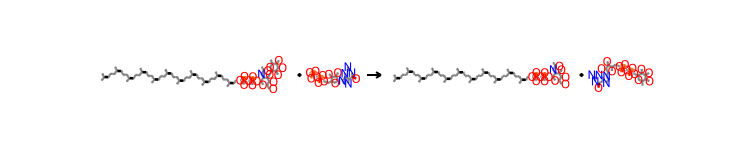

In [220]:
AllChem.ReactionFromSmarts(rxn['smarts'])

Any;Any >> Any;Any
[#6:1]-[#8:2].[#8:3]>>[#6:1]-[#8:3].[#8:2]


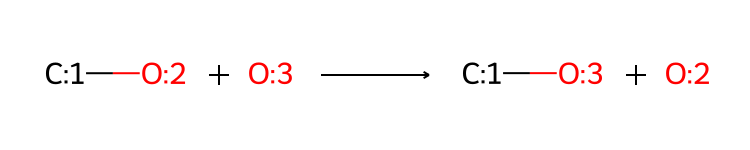

In [236]:
rule = 1 # 34 121
print(min_rules.loc[rule - 1, 'Reactants'], '>>', min_rules.loc[rule - 1, 'Products'])
print(min_rules.loc[rule - 1, "SMARTS"])
AllChem.ReactionFromSmarts(min_rules.loc[rule - 1, "SMARTS"])

8


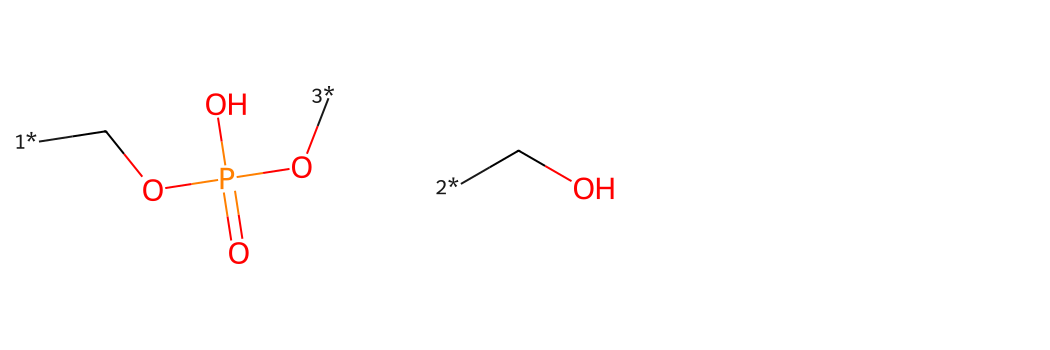

In [245]:
op = AllChem.ReactionFromSmarts(min_rules.loc[rule - 1, "SMARTS"])
r = ['[1*]COC[2*]', 'OP(=O)(O)O[3*]']
rcts = [Chem.MolFromSmiles(elt) for elt in r]
outputs = op.RunReactants(rcts)
print(len(outputs))
Draw.MolsToGridImage(outputs[0], subImgSize=(350, 350))

# Break up into chunks to map

In [ ]:
sprhea_v3 = load_json('/home/spn1560/bottle/data/sprhea/sprhea_240310_v3.json')

In [ ]:
# Break into pieces
n_chunks = 20
split_up = [{} for _ in range(n_chunks)]

for idx, key in enumerate(sprhea_v3):
    chunk_idx = idx % n_chunks
    split_up[chunk_idx][key] = sprhea_v3[key]

for i, part in enumerate(split_up):
    save_json(part, f"/home/spn1560/bottle/data/sprhea/sprhea_v3_part_{i}.json")

In [24]:
j = -1

In [44]:
j +=1
lines = []
with open("/home/spn1560/bottle/scripts/submit_pref.sh", 'r') as f:
    for line in f.readlines():
        lines.append(line.strip())

lines += [f"python -u map_operators.py /home/spn1560/bottle/data/rules/minimal1224_all_uniprot.tsv /home/spn1560/bottle/data/sprhea/sprhea_v3_part_{j}.json /home/spn1560/bottle/artifacts/operator_mapping_sprhea_v3_min_ops_part_{j}.tsv"]

with open("/home/spn1560/bottle/scripts/one_batch.sh", 'w') as f:
    for i, line in enumerate(lines):
        if i == len(lines) - 1:
            f.write(f"{line}")
        else:
            f.write(f"{line}\n")

# subprocess.run(args=["sbatch", "/home/spn1560/bottle/scripts/one_batch.sh"])
print(j)

19


In [ ]:
/home/spn1560/bottle/scripts/one_batch.sh

In [19]:
import os
print(os.getcwd())

/home/spn1560/bottle


# Clean up cofactors from rotation

In [2]:
# Load in cofactor dicts

unpaired = load_json('/home/stef/bottle/data/cofactors/smi2unpaired_cof.json')
paired = load_json('/home/stef/bottle/data/cofactors/smi2paired_cof.json')

# unpaired_imt = load_json('/home/stef/bottle/data/cofactors/smi2unpaired_cof_imt.json')
# paired_imt = load_json('/home/stef/bottle/data/cofactors/smi2paired_cof_imt.json')

# unpaired_min = load_json('/home/stef/bottle/data/cofactors/smi2unpaired_cof_min.json')
# paired_min = load_json('/home/stef/bottle/data/cofactors/smi2paired_cof_min.json')

In [5]:
# The unspecified ones are supersets of both min and imt
# print(set(paired_imt.keys()) - set(paired.keys()))
# print(set(paired_min.keys()) - set(paired.keys()))
# print(set(unpaired_imt.keys()) - set(unpaired.keys()))
# print(set(unpaired_min.keys()) - set(unpaired.keys()))

set()
set()
set()
set()


In [9]:
# The difference between the min and imt cofactors is 
# very minimal and only in the unpaired.. very overwrought, 
# younger Stefan. #

# print(set(paired_imt.keys()) ^ set(paired_min.keys()))
# print(set(paired_min.keys()) ^ set(paired_imt.keys()))
# print(set(unpaired_imt.keys()) ^ set(unpaired_min.keys()))

set()
set()
{'C#[O+]', 'I'}


In [29]:
# Create smi2name
smi2name = defaultdict(list)
for k, v in sprhea_v3.items():
    for smi, name in v['smi2name'].items():
        if name is not None:
            smi2name[smi].append(name)

for k,v in smi2name.items():
    smi2name[k] = ";".join(set(v))

In [15]:
rm_stereo = True
mismatch = set()
for k in unpaired:
    san_k = standardize_smiles(k, rm_stereo)
    if san_k != k:
        mismatch.add((k, san_k))

for k in paired:
    for smi in k.split(','):
        sansmi = standardize_smiles(smi, rm_stereo)
        if sansmi != smi:
            mismatch.add((smi, sansmi))

mismatch = list(mismatch)

[13:48:38] Initializing MetalDisconnector
[13:48:38] Running MetalDisconnector
[13:48:38] Initializing Normalizer
[13:48:38] Running Normalizer
[13:48:38] Initializing MetalDisconnector
[13:48:38] Running MetalDisconnector
[13:48:38] Initializing Normalizer
[13:48:38] Running Normalizer
[13:48:38] Running LargestFragmentChooser
[13:48:38] Fragment: CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O
[13:48:38] New largest fragment: CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O (89)
[13:48:38] Initializing MetalDisconnector
[13:48:38] Running MetalDisconnector
[13:48:38] Initializing Normalizer
[13:48:38] Running Normalizer
[13:48:38] Initializing MetalDisconnector
[13:48:38] Running MetalDisconnector
[13:48:38] Initializing Normalizer
[13:48:38] Running Normalizer
[13:48:38] Running LargestFragmentChooser
[13:48:38] Fragment: C#[O+]
[13:48:38] New largest fragment: C#[O+] (3)
[13:48:38] Initializi

In [37]:
mismatch

[('CC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCC1=CC(=O)C(C)=C(C)C1=O',
  'CC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCC=C(C)C=Cc1cc(O)c(C)c(C)c1O'),
 ('Nc1nc2c(ncn2C2CC(O)C(COP(=O)(O)O)O2)c(=O)[nH]1',
  'Nc1nc(=O)c2ncn(C3CC(O)C(COP(=O)(O)O)O3)c2[nH]1'),
 ('Nc1nc(O)nc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O)C1O',
  'Nc1[nH]c(=O)nc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O)C1O'),
 ('CC(Nc1ccc(CC(O)C(O)C(O)COC2OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O)C2O)cc1)C1=Nc2c(nc(N)[nH]c2=O)NC1C',
  'CC(=Nc1ccc(CC(O)C(O)C(O)COC2OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O)C2O)cc1)C1Nc2c([nH]c(N)nc2=O)NC1C'),
 ('Nc1nc2c(ncn2C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c(=O)[nH]1',
  'Nc1nc(=O)c2ncn(C3OC(COP(=O)(O)OP(=O)(O)O)C(O)C3O)c2[nH]1'),
 ('COc1c(O)c(C)c(CC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)C)c(O)c1OC',
  'COc1c(O)c(C)c(C=CC(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)C)c(O)c1OC'),
 ('CSC1=C(CCC(C)CCCC(C)CC

GDP


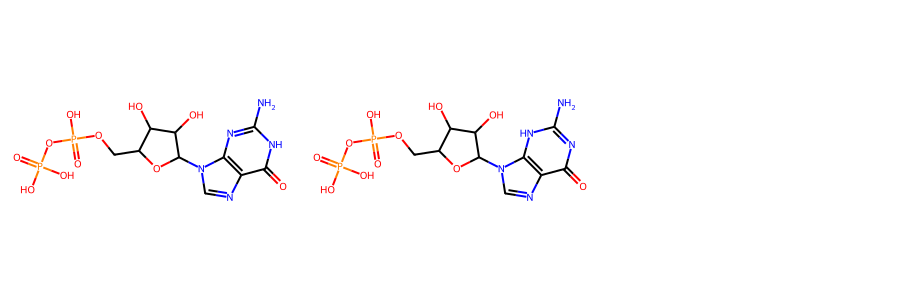

In [36]:
idx = 4
print(smi2name.get(mismatch[idx][1]))
Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in mismatch[idx]], subImgSize=(300, 300))

In [44]:
# Standardize smiles and save to lookups and reference
san_smi2paired = {}
san_smi2unpaired = {}
unpaired_ref = []
paired_ref = []
unpaired_cols = ['Class', 'Smiles', 'Name']
paired_cols = ['Class 1', 'Class 2', 'Smiles 1', 'Smiles 2', 'Name 1', 'Name 2']

for k, v in unpaired.items():
    san_k = standardize_smiles(k, rm_stereo)
    san_smi2unpaired[san_k] = v
    unpaired_ref.append([v, san_k, smi2name.get(san_k, None)])

for k, v in paired.items():
    smi1, smi2 = k.split(',')
    class1, class2 = v[0].split(',')
    sansmi1, sansmi2 = standardize_smiles(smi1, rm_stereo), standardize_smiles(smi2, rm_stereo)
    name1, name2 = smi2name.get(sansmi1, None), smi2name.get(sansmi2, None)
    paired_ref.append([class1, class2, sansmi1, sansmi2, name1, name2])
    san_smi2paired[','.join((sansmi1, sansmi2))] = ','.join((class1, class2))

[14:21:46] Initializing MetalDisconnector
[14:21:46] Running MetalDisconnector
[14:21:46] Initializing Normalizer
[14:21:46] Running Normalizer
[14:21:46] Initializing MetalDisconnector
[14:21:46] Running MetalDisconnector
[14:21:46] Initializing Normalizer
[14:21:46] Running Normalizer
[14:21:46] Running LargestFragmentChooser
[14:21:46] Fragment: CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O
[14:21:46] New largest fragment: CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O (89)
[14:21:46] Initializing MetalDisconnector
[14:21:46] Running MetalDisconnector
[14:21:46] Initializing Normalizer
[14:21:46] Running Normalizer
[14:21:46] Initializing MetalDisconnector
[14:21:46] Running MetalDisconnector
[14:21:46] Initializing Normalizer
[14:21:46] Running Normalizer
[14:21:46] Running LargestFragmentChooser
[14:21:46] Fragment: C#[O+]
[14:21:46] New largest fragment: C#[O+] (3)
[14:21:46] Initializi

In [58]:
save_json(san_smi2unpaired, '/home/stef/bottle/data/cofactors/smi2unpaired_cof.json')
save_json(san_smi2paired, '/home/stef/bottle/data/cofactors/smi2paired_cof.json')

In [59]:
pdf = pd.DataFrame(
    data=paired_ref,
    columns=paired_cols
)
pdf.head()
pdf.to_csv(
    path_or_buf='/home/stef/bottle/data/cofactors/paired_cofactors_reference.tsv',
    sep='\t',
    index=False
)

In [60]:
udf = pd.DataFrame(
    data=unpaired_ref,
    columns=unpaired_cols
)
udf.head()
udf.to_csv(
    path_or_buf='/home/stef/bottle/data/cofactors/unpaired_cofactors_reference.tsv',
    sep='\t',
    index=False
)

In [51]:
data = [[1,2, (1,2), ((1,2), (1,2))],
        [1,2,None, None]]
df = pd.DataFrame(data)
df.head()

,0,1,2,3
0,1,2,"(1, 2)","((1, 2), (1, 2))"
1,1,2,None,None


# RC-MCS investigation

In [ ]:
from src.rxn_ctr_mcs import get_lhs_patts_from_operator
import pandas as pd
from collections import defaultdict

In [ ]:
min_rules = pd.read_csv(
    '/home/stef/bottle/data/mapping/minimal1224_all_uniprot.tsv',
    sep='\t'
    )
min_rules.head()

,Name,Reactants,SMARTS,Products,Comments
0,rule0001,Any;Any,[#6:1]-[#8:2].[#8:3]>>[#6:1]-[#8:3].[#8:2],Any;Any,A0A060PLD9;A0A0P0YNP7;A0A0P9RZM9;A1XCQ0;A3E242...
1,rule0002,Any;NAD_CoF,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,NADH_CoF;Any,A0A023RBJ1;A0A060KZ16;A0A060TBM3;A0A072UJB3;A0...
2,rule0003,NADH_CoF;Any,[#6:1]1=[#6:2]-[#7:3]-[#6:4]=[#6:5]-[#6:6]-1.[...,Any;NAD_CoF,A0A023RBJ1;A0A060KZ16;A0A060TBM3;A0A072UJB3;A0...
3,rule0004,Any;NADH_CoF;O2,[#6:1].[#6:2]1=[#6:3]-[#7:4]-[#6:5]=[#6:6]-[#6...,Any;NAD_CoF;WATER,A0A1P8W705;A0A250DUW2;A1Z745;A5HMH6;A5HMH7;A5H...
4,rule0005,Any;NAD_CoF;WATER,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,Any;NADH_CoF;O2,A0A1P8W705;A0A250DUW2;A1Z745;A5HMH6;A5HMH7;A5H...


In [ ]:
duplicate_patts = []
for i, row in min_rules.iterrows():
    patts = get_lhs_patts_from_operator(row['SMARTS'])
    lhs = row['SMARTS'].split('>>')[0]
    template_names = row['Reactants'].split(';')

    patt_name = defaultdict(list)
    for patt, name in zip(patts, template_names):
        patt_name[patt].append(name)

    if len(patts) != len(set(patts)):
        duplicate_patts.append([row['Name'], patt_name])
    
    print(lhs, '-->', patts)

[#6:1]-[#8:2].[#8:3] --> ['[#6]-[#8]', '[#8]']
[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7+:7]:[#6:8]:1 --> ['[#6]-[#8]', '[#6]1:[#6]:[#6]:[#6]:[#7+]:[#6]:1']
[#6:1]1=[#6:2]-[#7:3]-[#6:4]=[#6:5]-[#6:6]-1.[#6:7]=[#8:8] --> ['[#6]1=[#6]-[#7]-[#6]=[#6]-[#6]-1', '[#6]=[#8]']
[#6:1].[#6:2]1=[#6:3]-[#7:4]-[#6:5]=[#6:6]-[#6:7]-1.[#8:8]=[#8:9] --> ['[#6]', '[#6]1=[#6]-[#7]-[#6]=[#6]-[#6]-1', '[#8]=[#8]']
[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7+:7]:[#6:8]:1.[#8:9] --> ['[#6]-[#8]', '[#6]1:[#6]:[#6]:[#6]:[#7+]:[#6]:1', '[#8]']
[#6:1]-[#8:2].[#8:3] --> ['[#6]-[#8]', '[#8]']
[#6:1]-[#8:2].[#8:3] --> ['[#6]-[#8]', '[#8]']
[#6:1]-[#8:2].[#8:3] --> ['[#6]-[#8]', '[#8]']
[#6:1]-[#8:2].[#8:3] --> ['[#6]-[#8]', '[#8]']
[#16:1].[#6:2]-[#8:3] --> ['[#16]', '[#6]-[#8]']
[#6:1]-[#16+:2].[#8:3] --> ['[#6]-[#16+]', '[#8]']
[#6:1]-[#8:2].[#7:3] --> ['[#6]-[#8]', '[#7]']
[#6:1]-[#7:2].[#8:3] --> ['[#6]-[#7]', '[#8]']
[#8:1].[#8:2]-[#15:3] --> ['[#8]', '[#8]-[#15]']
[#8:1].[#8:2]-[#15:3] --> ['[#8]', '

In [ ]:
duplicate_patts

[['rule0044',
  defaultdict(list, {'[#6]-[#8]': ['Any', 'Any'], '[#6]=[#8]': ['CO2']})],
 ['rule0072',
  defaultdict(list,
              {'[#6]1:[#6]:[#6]:[#6]:[#7+]:[#6]:1': ['NAD_CoF'],
               '[#6]=[#8]': ['Any'],
               '[#8]': ['WATER', 'WATER']})],
 ['rule0117', defaultdict(list, {'[#6]=[#8]': ['Any', 'Any']})],
 ['rule0149',
  defaultdict(list,
              {'[#6]-[#8]': ['Any'],
               '[#6]1:[#6]:[#6]:[#6]:[#7+]:[#6]:1': ['NAD_CoF'],
               '[#8]': ['WATER', 'WATER']})],
 ['rule0164',
  defaultdict(list,
              {'[#6]1=[#6]-[#7]-[#6]=[#6]-[#6]-1': ['NADH_CoF', 'NADH_CoF'],
               '[#6]=[#8]': ['Any']})],
 ['rule0165',
  defaultdict(list,
              {'[#6]': ['Any'],
               '[#6]1:[#6]:[#6]:[#6]:[#7+]:[#6]:1': ['NAD_CoF', 'NAD_CoF'],
               '[#8]': ['WATER']})],
 ['rule0179',
  defaultdict(list,
              {'[#16]': ['CoA'],
               '[#6]-[#8]': ['Any'],
               '[#6]1:[#6]:[#6]:[#6]:[#7+]:[#6]:

In [ ]:
min_rules.loc[43, 'SMARTS']

'[#6:1]-[#8:2].[#6:3]-[#8:4].[#6:5]=[#8:6]>>[#6:1].[#6:3]-[#6:5]-[#8:6].[#8:2]=[#8:4]'